In [1]:
#Qiskit includes
import qiskit
from qiskit.circuit import Instruction
from qiskit.visualization import plot_histogram
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, execute
from qiskit import Aer
from qiskit.providers.aer import noise
from qiskit import IBMQ
from qiskit.providers.aer.noise.errors.readout_error import *
from qiskit.circuit import Instruction
from qiskit.ignis.mitigation.measurement import (complete_meas_cal,
                                                 CompleteMeasFitter, 
                                                 MeasurementFilter)
#Other python tools
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.optimize import minimize
import seaborn as sns
import matplotlib.lines as mlines
%matplotlib inline

/usr/common/software/python/3.7-anaconda-2019.10/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#Extended Hamming code for n-qubit circuits correcting

def ext_h_cor(counts, n):
    #Counts are counts from circuit
    #n is number of qubits. 
    bit_strings = []
    parity = []
    
    #Deocding error message from bitstring and also tracking parity of the entire bitstring (error_bit = 0 indicates no error)
    #An
    for key in counts.keys():
        state = key[::-1]  #Holds a bit string from counts
        error_bit = 0      #Tracks error in parity and state bits (not the 0th bit)
        string_parity = 0  #Tracks the parity of the entire state (not the 0th bit)
        
        for k in range(len(state) ):
            if(state[k]=="1"):
                error_bit = error_bit ^ k
                pass
            pass
        for k in range(1, len(state)):
            if(state[k]=="1"):
                string_parity = (string_parity + 1)%2
                pass
            pass
        parity += [(error_bit, string_parity)] #Stores error value and parity of the string as a tuple
        bit_strings += [state]                 #Stores bit strings in a list
        pass

    import copy
    bit_strings_corrected = copy.deepcopy(bit_strings) #Copy bitstring list for correction
    counts_test = copy.deepcopy(counts)                #Copying counts to not alter original value

    #If the number of qubits are not a power of 2, it is possible to get erroneous results due to two or more bit flips
    #i.e. N = 7 could return an error of 7 if bits 2 and 5 are on. 
    #Find these and count them as 2-bit errors.
    N = int(np.ceil(math.log(n,2)))
    N = 2**N
    skip = []
    for i in range(n, N):
        skip +=[i]
        pass
    
    for i in range(len(parity)):
        #Check for impossible errors first
        if (parity[i][0] in skip):
            counts_test.pop(bit_strings[i][::-1]) #Remove from counts list.
            #We compare strings to identify single bit errors later, so we match them here so that the code skips them.
            bit_strings[i] = '0'
            bit_strings_corrected[i] = '0'
            continue
            pass

        #If error_bit is nonzero, there is an error
        if (parity[i][0] != 0 ):

            #If the parity of the bitstring equals the parity of the 0th bit, there have been at least two errors. We ignore these.
            if(parity[i][1] == int(bit_strings[i][0]) ):           
                counts_test.pop(bit_strings[i][::-1])
                bit_strings[i] = '0'
                bit_strings_corrected[i] = '0'
                continue
            #This does not catch errors in the 0th bit. 

            #Otherwise, there has been one error in the bit string. A corrected string is stored here.
            #We want to add these counts to the corrected bit string later.
            holder = list(bit_strings[i])
            holder[parity[i][0]] = str(1 - int(bit_strings[i][parity[i][0]]))
            holder = ''.join(holder)
            bit_strings_corrected[i] = holder

            continue


        #There could be error in the 0th bit. Add these to the corrected count and then erase from the lists.
        if(parity[i][1] != int(bit_strings[i][0]) ):
            foo = list(bit_strings[i])
            foo[0] = str(parity[i][1])
            foo = ''.join(foo)
            #print(foo, parity[i], int(bit_strings[i][0]))
            if(counts_test.get(foo[::-1]) == None):
                counts_test[foo[::-1]] = 0
                
            bit_strings_corrected[i] = foo
            counts_test[foo[::-1]] += counts_test[bit_strings[i][::-1]]

            counts_test.pop(bit_strings[i][::-1])
            bit_strings[i] = '0'
            bit_strings_corrected[i] = '0' 
            pass
        pass
    
    #Compare the corrected string and original. If discrepancy move counts to corrected string and remove incorrect state from counts.
    for i in range(len(bit_strings)):
        if (bit_strings[i] != bit_strings_corrected[i]):
            if(counts_test.get(bit_strings_corrected[i][::-1]) == None):
                counts_test[bit_strings_corrected[i][::-1]] = 0
            counts_test[bit_strings_corrected[i][::-1]] += counts_test[bit_strings[i][::-1]]
            counts_test.pop(bit_strings[i][::-1])
            pass
        pass
    
    return counts_test


In [3]:
#Extended Hamming code for n-qubit circuits. Detection only

def ext_h_det(counts, n):
    #Counts are counts from circuit
    #n is number of qubits. 
    bit_strings = []
    parity = []
    
    #Deocding error message from bitstring and also tracking parity of the entire bitstring (error_bit = 0 indicates no error)
    #An
    for key in counts.keys():
        state = key[::-1]  #Holds a bit string from counts
        error_bit = 0      #Tracks error in parity and state bits (not the 0th bit)
        string_parity = 0  #Tracks the parity of the entire state (not the 0th bit)
        
        for k in range(len(state) ):
            if(state[k]=="1"):
                error_bit = error_bit ^ k
                pass
            pass
        for k in range(1, len(state)):
            if(state[k]=="1"):
                string_parity = (string_parity + 1)%2
                pass
            pass
        parity += [(error_bit, string_parity)] #Stores error value and parity of the string as a tuple
        bit_strings += [state]                 #Stores bit strings in a list
        pass

    import copy
    bit_strings_corrected = copy.deepcopy(bit_strings) #Copy bitstring list for correction
    counts_test = copy.deepcopy(counts)                #Copying counts to not alter original value

    #If the number of qubits are not a power of 2, it is possible to get erroneous results due to two or more bit flips
    #i.e. N = 7 could return an error of 7 if bits 2 and 5 are on. 
    #Find these and count them as 2-bit errors.
    N = int(np.ceil(math.log(n,2)))
    N = 2**N
    skip = []
    for i in range(n, N):
        skip +=[i]
        pass
    
    for i in range(len(parity)):
        #Check for impossible errors first
        if (parity[i][0] in skip):
            counts_test.pop(bit_strings[i][::-1]) #Remove from counts list.
            #We compare strings to identify single bit errors later, so we match them here so that the code skips them.
            bit_strings[i] = '0'
            bit_strings_corrected[i] = '0'
            continue
            pass

        #If error_bit is nonzero, there is an error
        if (parity[i][0] != 0 ):

            #If the parity of the bitstring equals the parity of the 0th bit, there have been at least two errors. We ignore these.
            if(parity[i][1] == int(bit_strings[i][0]) ):           
                counts_test.pop(bit_strings[i][::-1])
                bit_strings[i] = '0'
                continue
            #This does not catch errors in the 0th bit. 

            #This checks for single flips, and removes them as well.
            counts_test.pop(bit_strings[i][::-1])
            continue

        #There could be error in the 0th bit. Remove these as well.
        if(parity[i][1] != int(bit_strings[i][0]) ):
            counts_test.pop(bit_strings[i][::-1])
            pass
        pass
    
    return counts_test


In [4]:
#Hamming code for n-qubit circuits. Detection Only

def h_det(counts, n):
    #Counts are counts from circuit
    #n is number of qubits. 
    bit_strings = []
    parity = []
    
    #Deocding error message from bitstring and also tracking parity of the entire bitstring (error_bit = 0 indicates no error)
    #An
    for key in counts.keys():
        state = key[::-1]  #Holds a bit string from counts
        error_bit = 0      #Tracks error in parity and state bits (not the 0th bit)
        
        for k in range(len(state) ):
            if(state[k]=="1"):
                error_bit = error_bit ^ k
                pass
            pass
        parity += [error_bit] #Stores error value and parity of the string as a tuple
        bit_strings += [state]                 #Stores bit strings in a list
        pass

    import copy
    bit_strings_corrected = copy.deepcopy(bit_strings) #Copy bitstring list for correction
    counts_test = copy.deepcopy(counts)                #Copying counts to not alter original value

    #If the number of qubits are not a power of 2, it is possible to get erroneous results due to two or more bit flips
    #i.e. N = 7 could return an error of 7 if bits 2 and 5 are on. 
    #Find these and count them as 2-bit errors.
    N = int(np.ceil(math.log(n,2)))
    N = 2**N
    skip = []
    for i in range(n, N):
        skip +=[i]
        pass
    
    for i in range(len(parity)):
        #Check for impossible errors first
        if (parity[i] in skip):
            counts_test.pop(bit_strings[i][::-1]) #Remove from counts list.
            #We compare strings to identify single bit errors later, so we match them here so that the code skips them.
            bit_strings[i] = '0'
            bit_strings_corrected[i] = '0'
            continue
            pass

        #If error_bit is nonzero, there is an error
        if (parity[i] != 0 ):
            #This checks for single flips, and removes them.
            counts_test.pop(bit_strings[i][::-1])
            continue
            
            pass
        pass
    
    return counts_test


In [5]:
#Hamming code for n-qubit circuits correcting

def h_cor(counts, n):
    #Counts are counts from circuit
    #n is number of qubits. 
    bit_strings = []
    parity = []
    
    #Deocding error message from bitstring and also tracking parity of the entire bitstring (error_bit = 0 indicates no error)
    #An
    for key in counts.keys():
        state = key[::-1]  #Holds a bit string from counts
        error_bit = 0      #Tracks error in parity and state bits (not the 0th bit)
        
        for k in range(len(state) ):
            if(state[k]=="1"):
                error_bit = error_bit ^ k
                pass
            pass
        parity += [error_bit] #Stores error value and parity of the string as a tuple
        bit_strings += [state]                 #Stores bit strings in a list
        pass

    import copy
    bit_strings_corrected = copy.deepcopy(bit_strings) #Copy bitstring list for correction
    counts_test = copy.deepcopy(counts)                #Copying counts to not alter original value

    for i in range(len(parity)):
        #If error_bit is nonzero, there is an error
        if (parity[i] != 0 ):
            #There has been one error in the bit string. A corrected string is stored here.
            #We want to add these counts to the corrected bit string later.
            holder = list(bit_strings[i])
            holder[parity[i]] = str(1 - int(bit_strings[i][parity[i]]))
            holder = ''.join(holder)
            bit_strings_corrected[i] = holder
         
    #Compare the corrected string and original. If discrepancy move counts to corrected string and remove incorrect state from counts.
    for i in range(len(bit_strings)):
        if (bit_strings[i] != bit_strings_corrected[i]):
            if(counts_test.get(bit_strings_corrected[i][::-1]) == None):
                counts_test[bit_strings_corrected[i][::-1]] = 0
            counts_test[bit_strings_corrected[i][::-1]] += counts_test[bit_strings[i][::-1]]
            counts_test.pop(bit_strings[i][::-1])
            pass
        pass
    
    return counts_test


In [6]:
#From Unfolding Paper for converting integers in to bitstrings
def mybin(input,q,r=1):
  if (r==0):
    return bin(input).split('b')[1].zfill(q) 
  else:
    return bin(input).split('b')[1].zfill(q)[::-1]  

# Testing Hamming Codes on Uniform Distribution

In [7]:
#Define number of qubits
N = 8
#Finds which bits will be parity bits and which bits contain other information.
state_bits = []
parity_bits = []

for i in range(0, N):
    if(i == 0): 
        continue
    if ((str(math.log(i,2)%2).split("."))[1] == "0"):
        parity_bits +=[i]
        continue
    else:
        state_bits += [i]
        pass
    pass
print("List of qubits which will contain information about the parity:", parity_bits)
print("List of qubits which will contain information about the state:",state_bits)

List of qubits which will contain information about the parity: [1, 2, 4]
List of qubits which will contain information about the state: [3, 5, 6, 7]


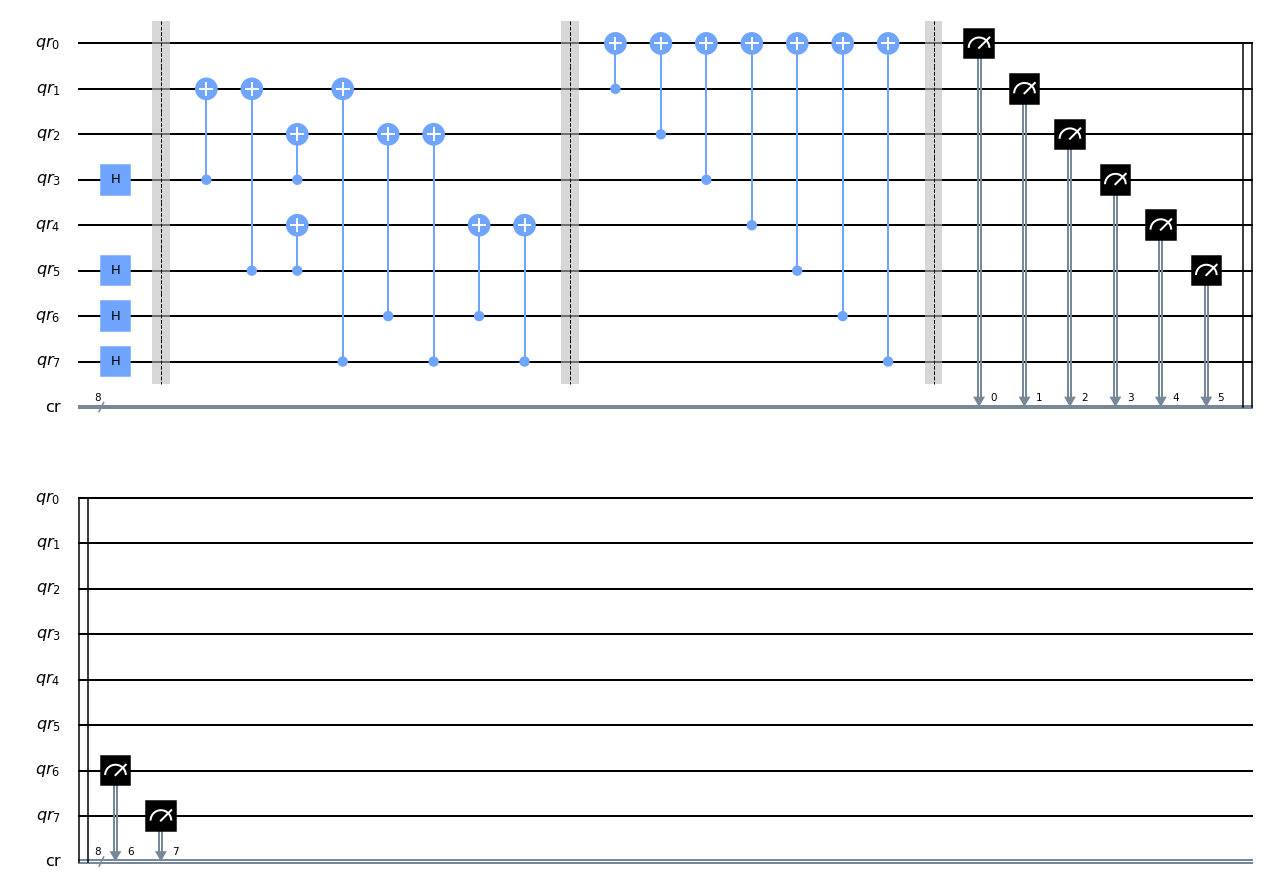

In [23]:
#Testing a uniform distribution
N = 8
Nstate_bits = len(state_bits)

qr = QuantumRegister(N, name="qr")
cr = ClassicalRegister(N, name="cr")

circ = QuantumCircuit(qr,cr)
circ.h(state_bits)
#circ.x(3)

circ.barrier()

for i in (parity_bits):
    for j in (state_bits):
        if(mybin(j,Nstate_bits)[int(math.log(i,2))] == "1" ):
            circ.cx(j, i)
            pass
        pass
    pass


circ.barrier()

for i in range(1,(len(qr))):
    circ.cx(i, 0)


#circ.cx(3, 0)
#circ.cx(5, 0)
#circ.cx(6, 0)

circ.barrier()
for i in range(0, len(qr)):
    circ.measure(i,i)
    
circ.draw('mpl')

In [24]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import thermal_relaxation_error

backend = qiskit.Aer.get_backend('qasm_simulator')


noise_model = NoiseModel()
q = 0.1
e = 0.1
readout = ReadoutError([[1-q, q], [q, 1-q]])
noise_model.add_all_qubit_readout_error(readout)
cx_error = noise.depolarizing_error(e,2)
noise_model.add_all_qubit_quantum_error(cx_error, ['cx'])

In [25]:
job = execute(circ, backend = backend, shots = 100000, noise_model = noise_model)
results = job.result()
counts = results.get_counts()

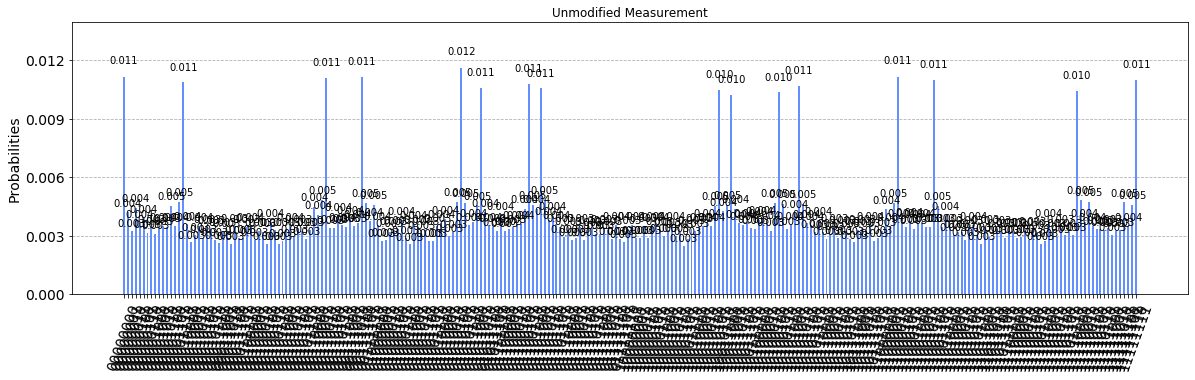

In [26]:
plot_histogram(counts,figsize=(20,5), title ="Unmodified Measurement")

In [27]:
counts_corrected = ext_h_cor(counts, N)

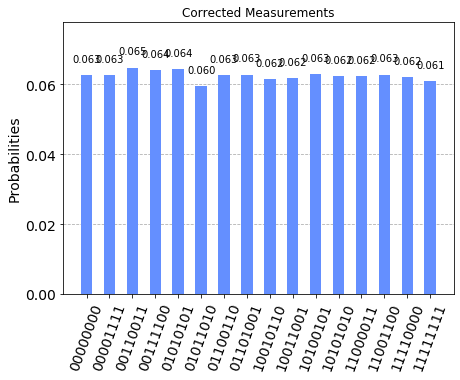

In [28]:
plot_histogram(counts_corrected, title = 'Corrected Measurements')

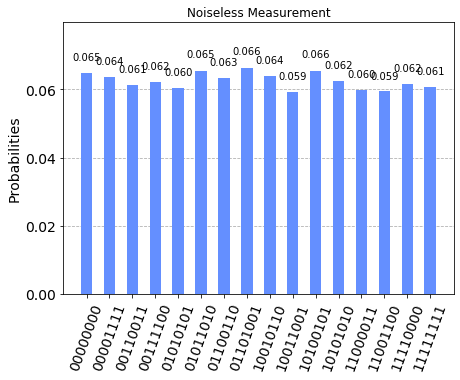

In [29]:
job_noiseless = execute(circ, backend = backend, shots = 10000)
results_noiseless = job_noiseless.result()
counts_noiseless = results_noiseless.get_counts()
plot_histogram(counts_noiseless, title="Noiseless Measurement")

# Response Matrix Calculations with Cirq

In [30]:
import cirq
import sympy
import sys

In [31]:
# define error channels

def add_depolarizing_noise(qubits, p) -> cirq.Moment:
    ''' error probability is 4/3 p (fully depolarizing is p=3/4)'''
    noise_component = []
    for qubit in qubits:
        noise_component.append(cirq.DepolarizingChannel(p)(qubit))
    return cirq.Moment(noise_component)

def add_two_qubit_depolarizing_noise(qubits, p) -> cirq.Moment:
    ''' error probability is p (fully depolarizing is p=15/16)'''
    errors =  ['XI','YI','ZI','IX','IY','IZ',
               'XX','YX','ZX','XY','YY','ZY','XZ','YZ','ZZ']
    error_probabilities = dict(zip(errors,[p/15]*15))
    
    component = cirq.AsymmetricDepolarizingChannel(error_probabilities=error_probabilities).on(*qubits)
    noise_component = []
    noise_component.append(component)
    return cirq.Moment(noise_component)
    
def add_dephasing_noise(qubits, p) -> cirq.Moment:
    noise_component = []
    for qubit in qubits:
        noise_component.append(cirq.PhaseDampingChannel(p)(qubit))
    return cirq.Moment(noise_component)

def add_damping_noise(qubits, p) -> cirq.Moment:
    noise_component = []
    for qubit in qubits:
        noise_component.append(cirq.AmplitudeDampingChannel(p)(qubit))
    return cirq.Moment(noise_component)

def add_measurement_noise(qubits, p) -> cirq.Moment:
    ''' with probability p apply x (fully mixed is p=0.5)'''
    noise_component = []
    for qubit in qubits:
        noise_component.append(cirq.bit_flip(p)(qubit))
    return cirq.Moment(noise_component)

In [32]:
#Finds possible bitstrings based on number of qubits.
N = 8
state_bits_r = []
parity_bits_r = []

#Finds which bits are parity bits and which bits are data bits
for i in range(0, N):
    if(i == 0): 
        continue
    if ((str(math.log(i,2)%2).split("."))[1] == "0"):
        parity_bits_r +=[i]
        continue
    else:
        state_bits_r += [i]
        pass
    pass

from itertools import combinations 
#Finds possible combinations of state bits 
combinations_r = [(0,)]
for i in range(1, len(state_bits_r)+1):
    combinations_r += combinations(state_bits_r,i)
    pass

#Finds possible bitstrings 
state_vectors = []
for i in range(len(combinations_r) ):
    #Finds state of data bits in binary
    val = 0
    binnumber_initial = ''
    for j in range(len(combinations_r[i])):
        val = val ^ combinations_r[i][j]
        pass
    val = mybin(val, N)
    
    #Finds correct bitstring based on which data bits are on in val
    #Finds parity bit by taking log_2(j) and seeing if it is an integer or not
    #If parity bit see if it is "on" by looking at position in val
    #Otherwise see if it is "on" by seeing it if is in combinations_r
    for j in range(N-1, 0, -1):
        if(str(math.log(j,2) % 2).split(".")[1] != "0" ):
            if(combinations_r[i].count(j) == 1):
                binnumber_initial = binnumber_initial + '1'
                pass
            else:
                binnumber_initial = binnumber_initial + '0'
                pass
            pass

        else:
            if(val[int(math.log(j,2))] == '1'):
                binnumber_initial = binnumber_initial + '1'
                pass
            else:
                binnumber_initial = binnumber_initial + '0'
        pass

    state_vectors +=[binnumber_initial]
    pass

#Adding on the final parity bit (for extended Hamming Code) by seeing parity of entire state
for i in range(len(state_vectors) ):
    p = 0
    for j in range(len(state_vectors[i])):
        p = int(state_vectors[i][j]) ^ p 
        pass
    state_vectors[i] = state_vectors[i] + str(p)
    pass           

print(state_vectors)

['00000000', '00001111', '00110011', '01010101', '10010110', '00111100', '01011010', '10011001', '01100110', '10100101', '11000011', '01101001', '10101010', '11001100', '11110000', '11111111']


In [25]:
#Use if want to use non extended correction code
state_vectors2 = []
for strings in state_vectors:
    state_vectors2 +=[strings[0:len(strings)-1] + '0']
    pass

In [33]:
def add_CNOT(circuit,qubit1,qubit2,epsilon):
    circuit.append(cirq.CNOT(qubit1,qubit2))
    if epsilon > 0:
        circuit.append(add_two_qubit_depolarizing_noise([qubit1,qubit2],p=epsilon))

def encoded_circuit(initialized_state, q, epsilon):
    #Logical state is list of qubits that should be "on" ie [3,5]
    
    qubits = cirq.LineQubit.range(8)
    
    circuit = cirq.Circuit()

    # initialize logical qubits
    for i in (initialized_state):
        if i == 0:
            continue
        else:
            circuit.append(cirq.X(qubits[i]) )
            pass
        pass
    
    #encoding logical bits
    add_CNOT(circuit,qubits[3],qubits[1],epsilon)
    add_CNOT(circuit,qubits[5],qubits[1],epsilon)
    add_CNOT(circuit,qubits[7],qubits[1],epsilon)
    
    add_CNOT(circuit,qubits[3],qubits[2],epsilon)
    add_CNOT(circuit,qubits[6],qubits[2],epsilon)
    add_CNOT(circuit,qubits[7],qubits[2],epsilon)
    
    add_CNOT(circuit,qubits[5],qubits[4],epsilon)
    add_CNOT(circuit,qubits[6],qubits[4],epsilon)
    add_CNOT(circuit,qubits[7],qubits[4],epsilon)
    
    
    #0th bit
    #circuit.append(cirq.I(qubits[0]))
    
    add_CNOT(circuit,qubits[1],qubits[0],epsilon)
    add_CNOT(circuit,qubits[2],qubits[0],epsilon)
    add_CNOT(circuit,qubits[3],qubits[0],epsilon)
    add_CNOT(circuit,qubits[4],qubits[0],epsilon)
    add_CNOT(circuit,qubits[5],qubits[0],epsilon)
    add_CNOT(circuit,qubits[6],qubits[0],epsilon)
    add_CNOT(circuit,qubits[7],qubits[0],epsilon)
    
    
    
    #add_CNOT(circuit,qubits[3],qubits[0],epsilon)
    #add_CNOT(circuit,qubits[5],qubits[0],epsilon)
    #add_CNOT(circuit,qubits[6],qubits[0],epsilon)
    
    
    
    # measurement noise
    circuit.append(add_measurement_noise(qubits,p=q))
    #circuit.append(add_measurement_noise(qubits[1:8],p=q)) #Removing measurement noise from 0th qubit for non extended code
    """
    for i in range(len(qubits)):
        circuit.append(cirq.measure(qubits[i]))
    """
    return circuit

In [34]:
encoded_circuit(combinations_r[0],0,0)

┌──┐   ┌───┐   ┌──┐
0: ───────────────────────X─────X───X───X───X───X───X───BF(0)───
                          │     │   │   │   │   │   │
1: ───X────X──────X───────@─────┼───┼───┼───┼───┼───┼───BF(0)───
      │    │      │             │   │   │   │   │   │
2: ───┼────┼X─────┼X──────X─────@───┼───┼───┼───┼───┼───BF(0)───
      │    ││     ││      │         │   │   │   │   │
3: ───@────┼@─────┼┼──────┼─────────@───┼───┼───┼───┼───BF(0)───
           │      ││      │             │   │   │   │
4: ────────┼──────┼┼X─────┼X────X───────@───┼───┼───┼───BF(0)───
           │      │││     ││    │           │   │   │
5: ────────@──────┼┼@─────┼┼────┼───────────@───┼───┼───BF(0)───
                  ││      ││    │               │   │
6: ───────────────┼@──────┼@────┼───────────────@───┼───BF(0)───
                  │       │     │                   │
7: ───────────────@───────@─────@───────────────────@───BF(0)───
          └──┘   └───┘   └──┘

In [18]:
#q = 0, e sweep
import timeit
import time

nqubits_r = 8

es = np.logspace(-4, -1, 30) *15/16 #to make consistent with qiskit
qs = [0.0]

traces_e = np.zeros((len(qs),len(es)) )
lost_e = np.zeros((len(qs),len(es)) )
benchmark_e = []

for i in range(len(qs)):
    #print('i :', i)
    for j in range(len(es)):
        start_time = timeit.default_timer()
        print('j :', j)
        #First find all possible states
        response_matrix = np.zeros((len(combinations_r),len(combinations_r)) )
        
        #Tracks the total amount of counts lost
        trashed = 0
        for k in range(len(combinations_r)):
            prob = {}
            
            #Computes response vector for one initialized state
            noisy_circuit = encoded_circuit(combinations_r[k], qs[i], es[j])
            rho_simulator = cirq.DensityMatrixSimulator(dtype=np.complex128)
            rho = rho_simulator.simulate(noisy_circuit).final_density_matrix 
            
            #Make dict of counts for one state
            for l in range(len(rho)):
                prob[mybin(l,8)] = np.real(rho[l,l])
                pass
            
            #Run correction code on that dict
            prob_corrected = ext_h_cor(prob, 8)
            
            #Add lost counts to trashed
            trashed += sum(prob_corrected.values()) - sum(prob.values())

            #Renormalize counts
            S = 0
            for l in prob_corrected.keys():
                S += prob_corrected.get(l, 0)
                pass
            
            for l in prob_corrected.keys():
                prob_corrected[l] = prob_corrected[l]/S
                pass
            
            #Add to response matrix
            for l in range(len(state_vectors)):
                response_matrix[l,k] = prob_corrected[state_vectors[l]]
            pass
        
            #add to trace
            traces_e[i,j] = np.trace(response_matrix)
        
        #Add total number of lost counts to lost, normalize, gives average counts lost
        lost_e[i,j] = trashed/16
        
        #Benchmarking
        benchmark_e += [timeit.default_timer() - start_time]
    pass



j : 0
j : 1
j : 2
j : 3
j : 4
j : 5
j : 6
j : 7
j : 8
j : 9
j : 10
j : 11
j : 12
j : 13
j : 14
j : 15
j : 16
j : 17
j : 18
j : 19
j : 20
j : 21
j : 22
j : 23
j : 24
j : 25
j : 26
j : 27
j : 28
j : 29


In [24]:
np.save('ext cor e sweep perfect 0', traces_e)
np.save('ext cor e sweep perfect 0 lost avg', lost_e)

In [37]:
#q sweep, e = 0
nqubits_r = 8

qs = np.logspace(-4, -1, 30)  #to make consistent with qiskit
es = [0.0]

traces_q = np.zeros((len(qs),len(es)) )
lost_q = np.zeros((len(qs),len(es)) )

benchmark_q = []
for i in range(len(qs)):
    start_time = timeit.default_timer()
    print('i :', i)
    for j in range(len(es)):
        #print('j :', j)
        #First find all possible states
        response_matrix = np.zeros((len(combinations_r),len(combinations_r)) )
        
        #Tracks the total amount of counts lost
        trashed = 0
        for k in range(len(combinations_r)):
            prob = {}
            
            #Computes response vector for one initialized state
            noisy_circuit = encoded_circuit(combinations_r[k], qs[i], es[j])
            rho_simulator = cirq.DensityMatrixSimulator(dtype=np.complex128)
            rho = rho_simulator.simulate(noisy_circuit).final_density_matrix 
            
            #Make dict of counts for one state
            for l in range(len(rho)):
                prob[mybin(l,8)] = np.real(rho[l,l])
                pass
            
            #Run correction code on that dict
            prob_corrected = h_det(prob, 8)
            
            #Add lost counts to trashed
            """
            for elements in prob:
                trashed += np.abs(prob_corrected.get(elements, 0) - prob.get(elements,0))
                pass
            """
            trashed += sum(prob_corrected.values()) - sum(prob.values())
                
            #Renormalize counts
            S = 0
            for l in prob_corrected.keys():
                S += prob_corrected.get(l, 0)
                pass
            
            for l in prob_corrected.keys():
                prob_corrected[l] = prob_corrected[l]/S
                pass
            
            #Add to response matrix
            for l in range(len(state_vectors2)):
                response_matrix[l,k] = prob_corrected[state_vectors2[l]]
            pass
        
            #add to trace
            traces_q[i,j] = np.trace(response_matrix) 
            pass
    
        #Tracks average number of counts lost per q and e combination
        lost_q[i,j] = trashed/16
    
        #Benchmarking
        benchmark_q += [timeit.default_timer() - start_time]
    pass


i : 0
i : 1
i : 2
i : 3
i : 4
i : 5
i : 6
i : 7
i : 8
i : 9
i : 10
i : 11
i : 12
i : 13
i : 14
i : 15
i : 16
i : 17
i : 18
i : 19
i : 20
i : 21
i : 22
i : 23
i : 24
i : 25
i : 26
i : 27
i : 28
i : 29


In [39]:
np.save('det q sweep', traces_q)
np.save('det q sweep lost avg', lost_q)

In [ ]:
#q sweep , e sweep
nqubits_r = 8

qs = np.logspace(-4,-1,10)
es = qs*15/16

traces_q_e = np.zeros((len(qs),len(es)) )
lost_q_e =  np.zeros((len(qs),len(es)) )

for i in range(len(qs)):
    print('i :', i)
    for j in range(len(es)):
        print('j :', j)
        
        #First find all possible states
        response_matrix = np.zeros((len(combinations_r),len(combinations_r)) )
        
        #Tracks total number of lost counts per q and e combo
        trashed = 0
        for k in range(len(combinations_r)):
            prob = {}
            
            #Computes response vector for one initialized state
            noisy_circuit = encoded_circuit(combinations_r[k], qs[i], es[j])
            rho_simulator = cirq.DensityMatrixSimulator(dtype=np.complex128)
            rho = rho_simulator.simulate(noisy_circuit).final_density_matrix 
            
            #Make dict of counts for one state
            for l in range(len(rho)):
                prob[mybin(l,8)] = np.real(rho[l,l])
                pass
            
            #Run correction code
            prob_corrected = ext_h_cor(prob, 8)

            trashed += sum(prob_corrected.values()) - sum(prob.values()) #This seems to be correct?
            
            #Renormalize counts
            S = 0
            for l in prob_corrected.keys():
                S += prob_corrected.get(l, 0)
                pass
            
            for l in prob_corrected.keys():
                prob_corrected[l] = prob_corrected[l]/S
                pass

            #Add to response matrix
            for l in range(len(state_vectors)):
                response_matrix[l,k] = prob_corrected[state_vectors[l]]
            
            #add to trace
            traces_q_e[i,j] = np.trace(response_matrix)
            pass
        #Stores average number of lost counts per q and e combination
        lost_q_e[i,j] = trashed/16
        pass
    pass


i : 0
j : 0
j : 1
j : 2
j : 3
j : 4
j : 5
j : 6
j : 7
j : 8
j : 9
i : 1
j : 0
j : 1
j : 2
j : 3
j : 4
j : 5
j : 6
j : 7
j : 8
j : 9
i : 2
j : 0
j : 1
j : 2
j : 3
j : 4
j : 5
j : 6
j : 7
j : 8
j : 9
i : 3
j : 0
j : 1
j : 2
j : 3
j : 4
j : 5
j : 6
j : 7
j : 8
j : 9
i : 4
j : 0
j : 1
j : 2
j : 3
j : 4
j : 5
j : 6
j : 7
j : 8
j : 9
i : 5
j : 0
j : 1
j : 2
j : 3
j : 4
j : 5
j : 6
j : 7
j : 8
j : 9
i : 6
j : 0
j : 1
j : 2
j : 3
j : 4
j : 5
j : 6
j : 7
j : 8
j : 9
i : 7
j : 0
j : 1
j : 2
j : 3
j : 4
j : 5
j : 6
j : 7
j : 8
j : 9
i : 8
j : 0
j : 1
j : 2
j : 3
j : 4
j : 5


In [ ]:
for i in range(len(traces_q_e)):
    for j in range(len(traces_q_e)):
        print("{:.5f}".format(traces_q_e[i,j]), end = ",")
        pass
    print()

In [34]:
np.save('ext cor, q sweep, e sweep, 10',traces_q_e)
np.save('ext cor avg lost 10', lost_q_e)

In [48]:
len(np.load('det, q sweep, e sweep, standard encoding.npy'))

30

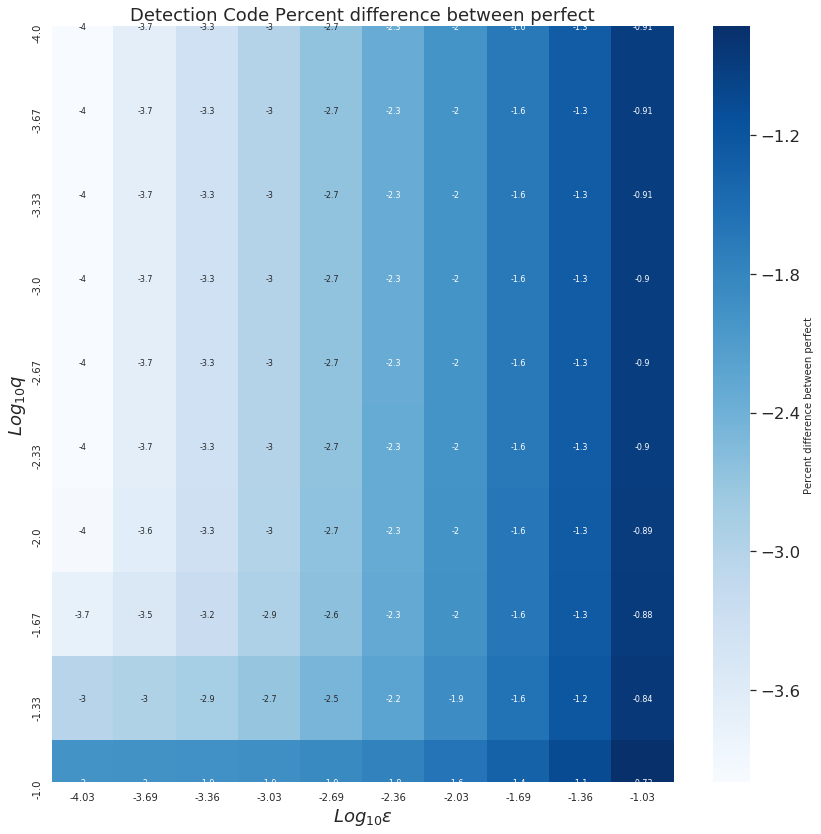

In [51]:
#For matrix of traces
index = 10
xvals = []
yvals = []
for i in range(index):
    xvals+=[i+0.5]
    yvals+=[i+0.5]
    pass


xlabs = []

es = np.logspace(-4, -1, index)*15/16
for i in range(len(es)):
    #xlabs += ['{:0.0e}'.format((qs[i]))]
    xlabs +=[str(round(np.log10(es[i]), 2))]
    pass

ylabs = []
qs = np.logspace(-4, -1, 10)
for i in range(len(qs)):
    #xlabs += ['{:0.0e}'.format((qs[i]))]
    ylabs +=[str(round(np.log10(qs[i]), 2))]

matrix =  np.log10(1- np.abs(np.load('det, q sweep, e sweep, 10.npy'))/16)

f = plt.figure(figsize=(15, 15))
sns.set(font_scale=1.5)
ax = sns.heatmap(matrix, annot = matrix, annot_kws={"size": 8},cmap="Blues", vmax = np.max(matrix), vmin = np.min(matrix))
ax.figure.axes[-1].yaxis.label.set_size(10)
cbar = ax.collections[0].colorbar
cbar.set_label('Percent difference between perfect')
plt.xticks(xvals,xlabs,fontsize=10)
plt.yticks(yvals,ylabs,fontsize=10)
plt.title('Detection Code Percent difference between perfect')
plt.ylabel('$Log_{10}{q}$',fontsize=18)
plt.xlabel('$Log_{10}{\epsilon}$',fontsize=18)
plt.subplots_adjust(bottom=0.18,left=0.18)
#plt.savefig("",bbox_inches='tight')

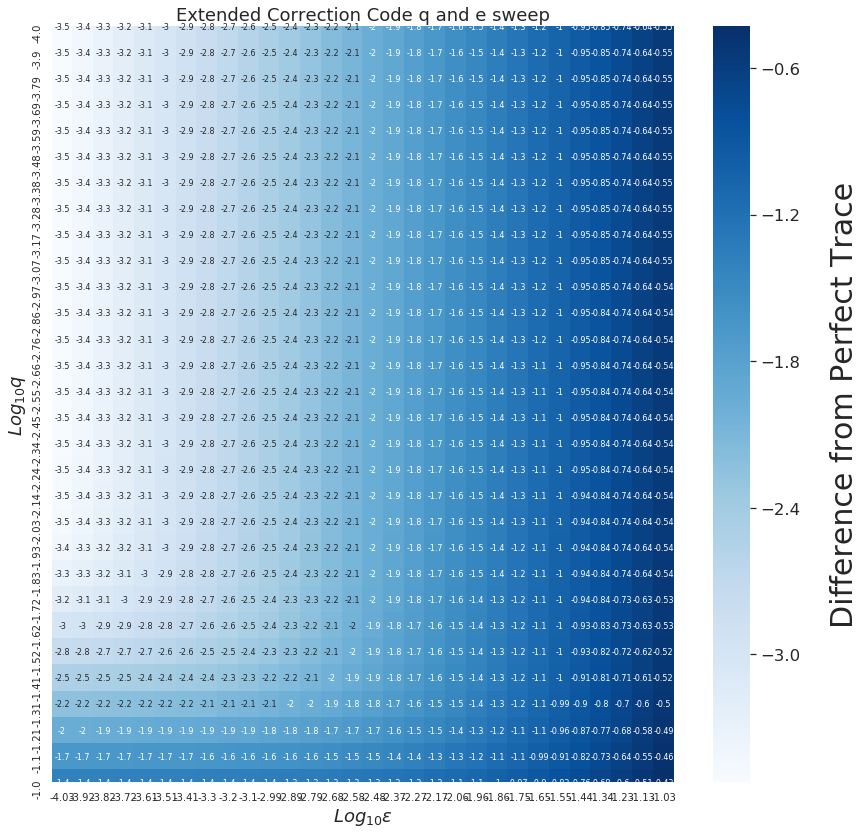

In [50]:
#For matrix of traces
index = 30
xvals = []
yvals = []
for i in range(index):
    xvals+=[i+0.5]
    yvals+=[i+0.5]
    pass


xlabs = []

es = np.logspace(-4, -1, 30)*15/16
for i in range(len(es)):
    #xlabs += ['{:0.0e}'.format((qs[i]))]
    xlabs +=[str(round(np.log10(es[i]), 2))]
    pass

ylabs = []
qs = np.logspace(-4, -1, 30)
for i in range(len(qs)):
    #xlabs += ['{:0.0e}'.format((qs[i]))]
    ylabs +=[str(round(np.log10(qs[i]), 2))]

matrix = np.log10(1 - np.load('ext cor, q sweep, e sweep, 30.npy')/16)

f = plt.figure(figsize=(15, 15))
sns.set(font_scale=1.5)
ax = sns.heatmap(matrix, annot = matrix, annot_kws={"size": 8},cmap="Blues", vmax = np.max(matrix), vmin = np.min(matrix))
ax.figure.axes[-1].yaxis.label.set_size(30)
cbar = ax.collections[0].colorbar
cbar.set_label('Difference from Perfect Trace', labelpad=30)
plt.xticks(xvals,xlabs,fontsize=10)
plt.yticks(yvals,ylabs,fontsize=10)
plt.title('Extended Correction Code q and e sweep')
plt.ylabel('$Log_{10}{q}$',fontsize=18)
plt.xlabel('$Log_{10}{\epsilon}$',fontsize=18)
plt.subplots_adjust(bottom=0.18,left=0.18)
#plt.savefig("",bbox_inches='tight')


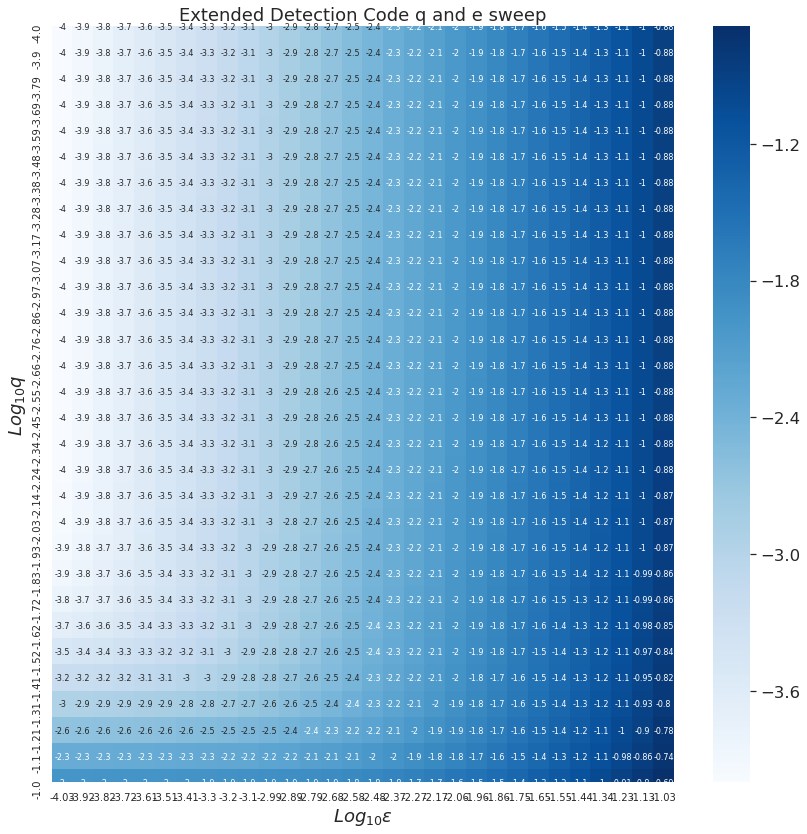

In [52]:
#For matrix of traces
index = 30
xvals = []
yvals = []
for i in range(index):
    xvals+=[i+0.5]
    yvals+=[i+0.5]
    pass


xlabs = []

es = np.logspace(-4, -1, 30)*15/16
for i in range(len(es)):
    #xlabs += ['{:0.0e}'.format((qs[i]))]
    xlabs +=[str(round(np.log10(es[i]), 2))]
    pass

ylabs = []
qs = np.logspace(-4, -1, 30)
for i in range(len(qs)):
    #xlabs += ['{:0.0e}'.format((qs[i]))]
    ylabs +=[str(round(np.log10(qs[i]), 2))]

matrix = np.log10(1 - np.load('ext det, q sweep, e sweep, 30.npy')/16)

f = plt.figure(figsize=(15, 15))
sns.set(font_scale=1.5)
ax = sns.heatmap(matrix, annot = matrix, annot_kws={"size": 8},cmap="Blues", vmax = np.max(matrix), vmin = np.min(matrix))
ax.figure.axes[-1].yaxis.label.set_size(30)
cbar = ax.collections[0].colorbar
cbar.set_label('', labelpad=30)
plt.xticks(xvals,xlabs,fontsize=10)
plt.yticks(yvals,ylabs,fontsize=10)
plt.title('Extended Detection Code q and e sweep')
plt.ylabel('$Log_{10}{q}$',fontsize=18)
plt.xlabel('$Log_{10}{\epsilon}$',fontsize=18)
plt.subplots_adjust(bottom=0.18,left=0.18)
#plt.savefig("",bbox_inches='tight')


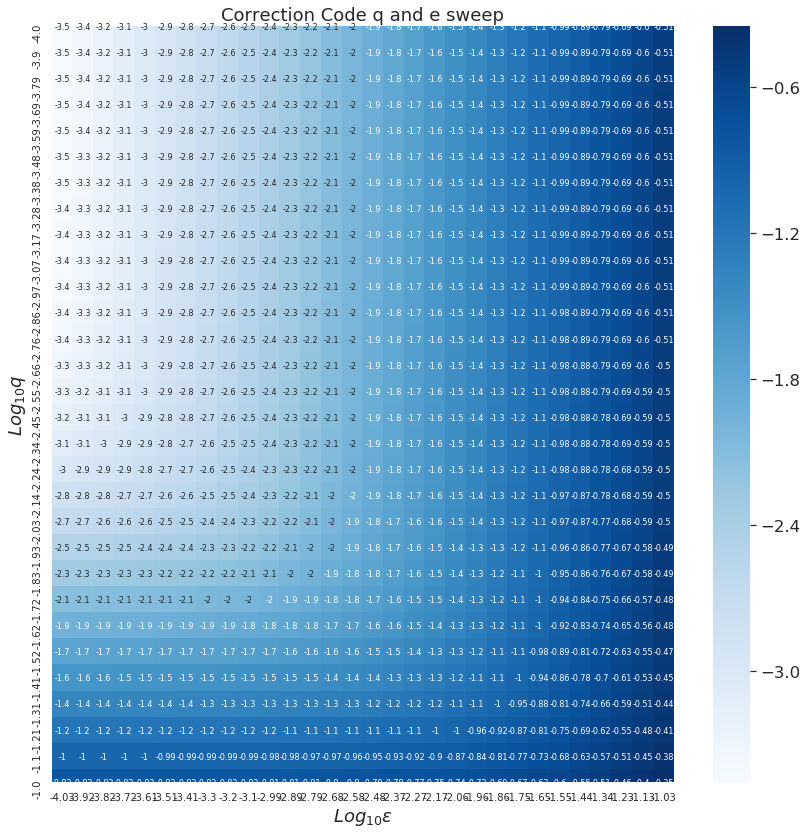

In [53]:
#For matrix of traces
index = 30
xvals = []
yvals = []
for i in range(index):
    xvals+=[i+0.5]
    yvals+=[i+0.5]
    pass


xlabs = []

es = np.logspace(-4, -1, 30)*15/16
for i in range(len(es)):
    #xlabs += ['{:0.0e}'.format((qs[i]))]
    xlabs +=[str(round(np.log10(es[i]), 2))]
    pass

ylabs = []
qs = np.logspace(-4, -1, 30)
for i in range(len(qs)):
    #xlabs += ['{:0.0e}'.format((qs[i]))]
    ylabs +=[str(round(np.log10(qs[i]), 2))]
    

matrix = np.log10(1 - np.load('cor, q sweep, e sweep, 30.npy')/16)

f = plt.figure(figsize=(15, 15))
sns.set(font_scale=1.5)
ax = sns.heatmap(matrix, annot = matrix, annot_kws={"size": 8},cmap="Blues", vmax = np.max(matrix), vmin = np.min(matrix))
ax.figure.axes[-1].yaxis.label.set_size(30)
cbar = ax.collections[0].colorbar
cbar.set_label('', labelpad=30)
plt.xticks(xvals,xlabs,fontsize=10)
plt.yticks(yvals,ylabs,fontsize=10)
plt.title('Correction Code q and e sweep')
plt.ylabel('$Log_{10}{q}$',fontsize=18)
plt.xlabel('$Log_{10}{\epsilon}$',fontsize=18)
plt.subplots_adjust(bottom=0.18,left=0.18)
#plt.savefig("",bbox_inches='tight')


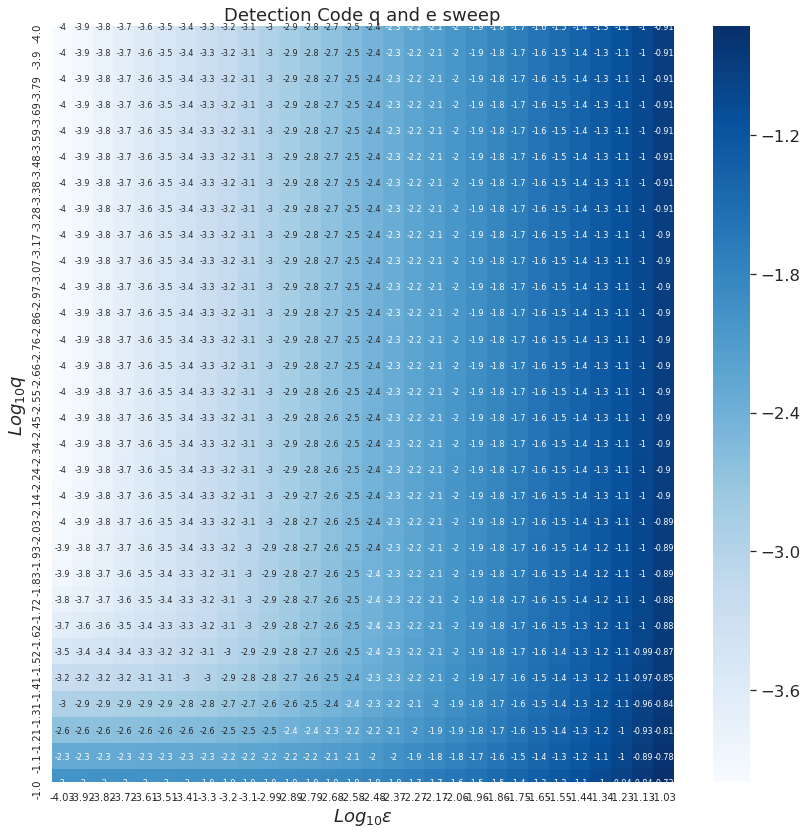

In [35]:
#For matrix of traces
index = 30
xvals = []
yvals = []
for i in range(index):
    xvals+=[i+0.5]
    yvals+=[i+0.5]
    pass


xlabs = []

es = np.logspace(-4, -1, 30)*15/16
for i in range(len(es)):
    #xlabs += ['{:0.0e}'.format((qs[i]))]
    xlabs +=[str(round(np.log10(es[i]), 2))]
    pass

ylabs = []
qs = np.logspace(-4, -1, 30)
for i in range(len(qs)):
    #xlabs += ['{:0.0e}'.format((qs[i]))]
    ylabs +=[str(round(np.log10(qs[i]), 2))]

matrix = np.log10(1 - np.load('det, q sweep, e sweep, 30.npy')/16)

f = plt.figure(figsize=(15, 15))
sns.set(font_scale=1.5)
ax = sns.heatmap(matrix, annot = matrix, annot_kws={"size": 8},cmap="Blues", vmax = np.max(matrix), vmin = np.min(matrix))
ax.figure.axes[-1].yaxis.label.set_size(30)
cbar = ax.collections[0].colorbar
cbar.set_label('', labelpad=30)
plt.xticks(xvals,xlabs,fontsize=10)
plt.yticks(yvals,ylabs,fontsize=10)
plt.title('Detection Code q and e sweep')
plt.ylabel('$Log_{10}{q}$',fontsize=18)
plt.xlabel('$Log_{10}{\epsilon}$',fontsize=18)
plt.subplots_adjust(bottom=0.18,left=0.18)
#plt.savefig("",bbox_inches='tight')


Text(0.5, 1.0, 'E sweep')

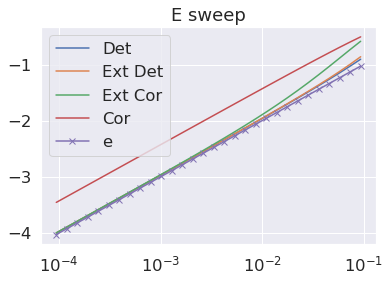

In [105]:
es = np.logspace(-4, -1, 30)*15/16
qs = np.logspace(-4, -1, 30)

det =np.log10 (1 - np.load('det e sweep.npy')[0]/16)
ext_det = np.log10(1 - np.load('ext det e sweep.npy')[0]/16)
ext_cor  = np.log10(1 - np.load('ext cor e sweep.npy')[0]/16)
cor  = np.log10(1 - np.load('cor e sweep.npy')[0]/16)

plt.plot(es, det, label = 'Det')
plt.plot(es, ext_det, label = 'Ext Det')
plt.plot(es, ext_cor, label = 'Ext Cor')
plt.plot(es, cor, label= 'Cor')

plt.plot(es, np.log10(es), label = 'e', marker = 'x')

plt.xscale('log')
plt.legend()
plt.title('E sweep')

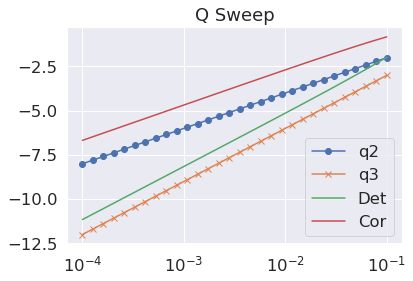

In [103]:
qs = np.logspace(-4, -1, 30)
det = np.log10(1 - np.load('det q sweep.npy')/16)
ext_det = np.log10(1 - np.load('ext det q sweep.npy')/16)
ext_cor  = np.log10(1 - np.load('ext cor q sweep.npy')/16)
cor  = np.log10(1 - np.load('cor q sweep.npy')/16)


q2 =(qs**2)
q3 =(qs**3)

plt.plot(qs, np.log10(q2), label= 'q2', marker = 'o')
plt.plot(qs, np.log10(q3), label= 'q3', marker = 'x')

plt.plot(qs, det, label = 'Det')
#plt.plot(qs, ext_det, label = 'Ext Det')
#plt.plot(qs, ext_cor, label = 'Ext Cor')
plt.plot(qs, cor, label= 'Cor')

plt.xscale('log')
plt.legend()
plt.title('Q Sweep')
plt.show()